In [9]:
import numpy as np
import pandas as pd
import os, re, math, platform
from pathlib import Path
import matplotlib.pyplot as plt
import json
import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score
from imblearn.metrics import geometric_mean_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from matplotlib import pyplot
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score
from fea_extract import read_fasta,insert_AAC,insert_DPC,insert_CKSAAGP,insert_CTD,insert_PAAC,insert_AAI,insert_GTPC,insert_QSO,insert_AAE,insert_PSAAC,insert_word2int,insert_ASDC
import warnings 
from tools import cv,evaluate
warnings.filterwarnings('ignore')
seed = 10
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
Path('./results/predict_proba/').mkdir(exist_ok=True,parents=True)
Path('./results/evaluate/').mkdir(exist_ok=True,parents=True)
Path('./results/model/').mkdir(exist_ok=True,parents=True)

In [10]:
GBDT = GradientBoostingClassifier(random_state=seed)
ET = ExtraTreesClassifier(random_state=seed)
SVM = SVC(random_state=seed,probability=True)
MLP = MLPClassifier(hidden_layer_sizes=64,learning_rate="adaptive",random_state=seed)
RF = RandomForestClassifier(random_state=seed)
XGBoost = XGBClassifier(random_state=seed)
LR  = LogisticRegression(random_state=seed)
AB = AdaBoostClassifier(random_state=seed)
clf_feature_order = {
#     "GA": ["XGBoost","RF","ET","GBDT"],
    "Boruta": ["XGBoost","RF","ET","GBDT"],
#     "Fscore": ["XGBoost","RF","ET","GBDT"],
#     "MI": ["XGBoost","RF","ET","GBDT"],
    "MRMD": ["XGBoost","RF","ET","GBDT"],
    "XGB": ["XGBoost","RF","ET","GBDT"],
#     "RFE": ["XGBoost","RF","ET","GBDT"],
}
ml = ["XGBoost","RF","ET","GBDT",'AB']

In [11]:
#定义基学习器
def base_clf(clf,X_train,y_train,model_name,n_folds=5):
    ntrain = X_train.shape[0] #训练样本个数。
    nclass = len(np.unique(y_train)) #类别个数。
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)#K-折叠交叉验证。
    base_pf_train = np.zeros((ntrain,nclass)) #返回给定形状和类型的新数组，用零填充。
    base_cf_train = np.zeros((ntrain))
    
    for train_index, test_index in kf.split(X_train,y_train):
        kf_X_train,kf_y_train = X_train[train_index],y_train[train_index]
        kf_X_test = X_train[test_index]

        clf.fit(kf_X_train, kf_y_train)
        base_pf_train[test_index] = clf.predict_proba(kf_X_test)
        base_cf_train[test_index] = clf.predict(kf_X_test)
    clf.fit(X_train,y_train)
    joblib.dump(model,f'./results/model/{model_name}')
    return base_pf_train[:,-1], base_cf_train

In [12]:
X_train_base_pf = []
X_test_base_pf = []
X_train_base_cf = []
X_test_base_cf = []
X_train_base_pcf = []
X_test_base_pcf = []

all_eval_dic = []
Index = []
index = []
ALL_evals_train = pd.DataFrame()
for (n,m) in clf_feature_order.items():
    X_train = pd.read_csv('Feature_different/X_train_{}.csv'.format(n)).to_numpy()
    X_test = pd.read_csv('Feature_different/X_test_{}.csv'.format(n)).to_numpy()
    y_train = pd.read_csv('data/train/y_train_resampled.csv').to_numpy()
    y_test = pd.read_csv('data/test/y_test.csv').to_numpy()
#     np.random.seed(1234)
#     idx = np.random.permutation(len(X_train))
#     X_train = X_train[idx]
#     y_train = y_train[idx]

    for c in m:
        model = eval(c)
        print("{}_{:s}".format(n,c))
        X_train_pf,X_train_cf = base_clf(model,X_train,y_train,f'{n}_{c}.m')
        Evals = cv(model,X_train,y_train)
        ALL_evals_train = pd.concat([ALL_evals_train,Evals],axis=1)
        index.append('{}_{}'.format(n,c))
                # PF
        X_train_base_pf.append(X_train_pf) 
        X_train_pf_dic = np.array(X_train_base_pf).T
             # CF
        X_train_base_cf.append(X_train_cf) 
        X_train_cf_dic = np.array(X_train_base_cf).T
        # PCF
        X_train_base_pcf.append(X_train_pf)
        X_train_base_pcf.append(X_train_cf)
        X_train_pcf_dic = np.array(X_train_base_pcf).T

        base_model = joblib.load('results/model/{}_{}.m'.format(n,c))
                # PF
        X_test_pf = base_model.predict_proba(X_test)[:,-1]
        X_test_base_pf.append(X_test_pf) 
        X_test_pf_dic = np.array(X_test_base_pf).T
                # CF
        X_test_cf = base_model.predict(X_test)
        X_test_base_cf.append(X_test_cf) 
        X_test_cf_dic = np.array(X_test_base_cf).T
                # PCF
        X_test_base_pcf.append(X_test_pf)
        X_test_base_pcf.append(X_test_cf)
        X_test_pcf_dic = np.array(X_test_base_pcf).T
        Index.append("{}_{}".format(n,c))

        eval_dic = evaluate(X_test,y_test,base_model)
#     print("test：",eval_dic)
        all_eval_dic = all_eval_dic+[eval_dic]
    
all_eval_dic = pd.DataFrame(all_eval_dic,index=Index) #
all_eval_dic.to_csv(os.path.join("results/evaluate/tow_evalu.csv"))
# all_eval_dic.plot.bar(figsize=(20,10),fontsize=15,rot=45,grid = False, width = 0.7,title="{:s}".format(m))

#输出概率向量  
#训练集
X_train_pf_dic = pd.DataFrame(X_train_pf_dic)
X_train_pf_dic.to_csv(os.path.join("results/predict_proba/X_train_pf.csv"),index=False)
X_train_cf_dic = pd.DataFrame(X_train_cf_dic)
X_train_cf_dic.to_csv(os.path.join("results/predict_proba/X_train_cf.csv"),index=False)
X_train_pcf_dic = pd.DataFrame(X_train_pcf_dic)
X_train_pcf_dic.to_csv(os.path.join("results/predict_proba/X_train_pcf.csv"),index=False)
y_train = pd.DataFrame(y_train)
y_train.to_csv(os.path.join("results/y_train.csv"),index=False)
#测试集
X_test_cf_dic = pd.DataFrame(X_test_cf_dic)
X_test_cf_dic.to_csv(os.path.join("results/predict_proba/X_test_cf.csv"),index=False)
X_test_pf_dic = pd.DataFrame(X_test_pf_dic)
X_test_pf_dic.to_csv(os.path.join("results/predict_proba/X_test_pf.csv"),index=False)
X_test_pcf_dic = pd.DataFrame(X_test_pcf_dic)
X_test_pcf_dic.to_csv(os.path.join("results/predict_proba/X_test_pcf.csv"),index=False)
y_test = pd.DataFrame(y_test)
y_test.to_csv(os.path.join("results/y_test.csv"),index=False)

Boruta_XGBoost
Boruta_RF
Boruta_ET
Boruta_GBDT
MRMD_XGBoost
MRMD_RF
MRMD_ET
MRMD_GBDT
XGB_XGBoost
XGB_RF
XGB_ET
XGB_GBDT


In [14]:
ALL_evals_train

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ACC,0.982085,0.984575,0.993032,0.975613,0.985566,0.988053,0.998010,0.983077,0.986560,0.985066,0.998506,0.984073,0.986558,0.990546,0.998007,0.984571
F1,0.985568,0.987730,0.994535,0.980507,0.988404,0.990393,0.998416,0.986516,0.989179,0.988003,0.998815,0.987229,0.989220,0.992372,0.998424,0.987762
F2,0.984522,0.985914,0.995433,0.982525,0.988082,0.988883,0.998402,0.986856,0.987944,0.987921,0.999525,0.987615,0.988405,0.990164,0.998890,0.988317
GMean,0.980922,0.983666,0.991673,0.972199,0.984339,0.987692,0.997799,0.981058,0.986077,0.983710,0.997957,0.982323,0.985619,0.990821,0.997536,0.982381
SEN,0.983845,0.984729,0.996039,0.983890,0.987884,0.987897,0.998393,0.987097,0.987133,0.987881,1.000000,0.987881,0.987881,0.988710,0.999203,0.988707
PREC,0.987394,0.990856,0.993068,0.977217,0.989007,0.992997,0.998444,0.986003,0.991290,0.988201,0.997635,0.986618,0.990655,0.996125,0.997654,0.986912
SPEC,0.978092,0.982751,0.987367,0.960735,0.980881,0.987574,0.997212,0.975149,0.985068,0.979631,0.995921,0.976842,0.983455,0.992984,0.995881,0.976225
MCC,0.961917,0.966895,0.984878,0.947789,0.969269,0.974647,0.995725,0.963711,0.971392,0.968192,0.996777,0.965955,0.971369,0.979988,0.995710,0.966828
AUC,0.997754,0.998690,0.999650,0.997667,0.998528,0.998955,0.999978,0.998280,0.998321,0.999249,1.000000,0.998342,0.998775,0.999582,0.999987,0.998608


In [13]:
all_eval_dic

,ACC,F1,F2,GMean,SEN,PREC,SPEC,MCC,AUC,AUPR
Boruta_XGBoost,0.895105,0.563107,0.728643,0.900208,0.90625,0.408451,0.894207,0.565897,0.946001,0.742464
Boruta_RF,0.906760,0.574468,0.710526,0.877134,0.84375,0.435484,0.911839,0.564582,0.939822,0.653450
Boruta_ET,0.902098,0.580000,0.739796,0.904004,0.90625,0.426471,0.901763,0.581274,0.945686,0.678939
Boruta_GBDT,0.888112,0.555556,0.735294,0.910425,0.93750,0.394737,0.884131,0.565396,0.939310,0.554444
MRMD_XGBoost,0.876457,0.513761,0.682927,0.875787,0.87500,0.363636,0.876574,0.514548,0.945529,0.719694
MRMD_RF,0.890443,0.543689,0.703518,0.883304,0.87500,0.394366,0.891688,0.542023,0.938917,0.652368
MRMD_ET,0.890443,0.525253,0.666667,0.853574,0.81250,0.388060,0.896725,0.513290,0.941633,0.625011
MRMD_GBDT,0.857809,0.487395,0.674419,0.879688,0.90625,0.333333,0.853904,0.496706,0.920576,0.642158
XGB_XGBoost,0.885781,0.542056,0.714286,0.895122,0.90625,0.386667,0.884131,0.546732,0.954503,0.747171
XGB_RF,0.892774,0.549020,0.707071,0.884551,0.87500,0.400000,0.894207,0.546911,0.941514,0.662093


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
all_eval = pd.read_csv('results/evaluate/tow_evalu.csv')

In [21]:
all_eval_dic

,ACC,F1,F2,GMean,SEN,PREC,SPEC,MCC,AUC
Boruta_XGBoost,0.895105,0.563107,0.728643,0.900208,0.90625,0.408451,0.894207,0.565897,0.946001
Boruta_RF,0.906760,0.574468,0.710526,0.877134,0.84375,0.435484,0.911839,0.564582,0.939822
Boruta_ET,0.902098,0.580000,0.739796,0.904004,0.90625,0.426471,0.901763,0.581274,0.945686
Boruta_GBDT,0.888112,0.555556,0.735294,0.910425,0.93750,0.394737,0.884131,0.565396,0.939310
MI_XGBoost,0.878788,0.527273,0.703883,0.891289,0.90625,0.371795,0.876574,0.533253,0.950252
MI_RF,0.878788,0.500000,0.650000,0.847559,0.81250,0.361111,0.884131,0.489748,0.939153
MI_ET,0.902098,0.553191,0.684211,0.859548,0.81250,0.419355,0.909320,0.539349,0.937933
MI_GBDT,0.855478,0.474576,0.654206,0.864388,0.87500,0.325581,0.853904,0.478349,0.941200
MRMD_XGBoost,0.885781,0.524272,0.678392,0.866162,0.84375,0.380282,0.889169,0.518150,0.946159
MRMD_RF,0.899767,0.547368,0.680628,0.858356,0.81250,0.412698,0.906801,0.533913,0.940019


<AxesSubplot:>

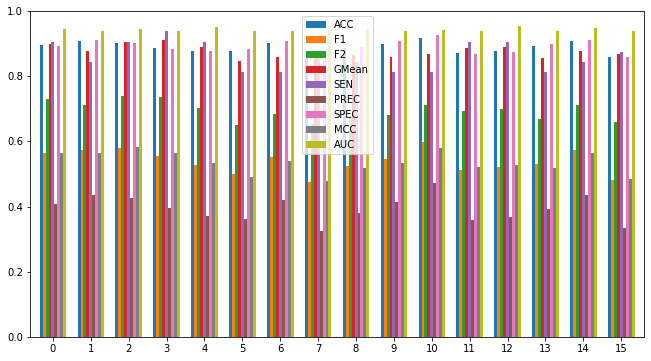

In [14]:
all_eval.plot.bar(figsize=(11,6),rot=0,width = 0.7,grid = False)